In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split,KFold,cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "Dataset/heg_sample_data.csv"
heg_meta = pd.read_csv(data_path)

drop_columns = ["delta_collect_timestamp_t-t1",
                "delta_collect_timestamp_t1-t2",
                "delta_document.temperatura_t2-t3",
                "delta_document.temperatura_t3-t4",
                "outcome"]

data_x = heg_meta.drop(columns = drop_columns)
data_y = heg_meta[['outcome']]

In [3]:
heg_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13652 entries, 0 to 13651
Data columns (total 73 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              13652 non-null  int64  
 1   days_from_entrance                      13652 non-null  float64
 2   age                                     13652 non-null  float64
 3   document.sexo                           13652 non-null  float64
 4   UTI                                     13652 non-null  float64
 5   delta_collect_timestamp_t-t1            13652 non-null  float64
 6   delta_collect_timestamp_t1-t2           13652 non-null  float64
 7   delta_collect_timestamp_t2-t3           13652 non-null  float64
 8   delta_collect_timestamp_t3-t4           13652 non-null  float64
 9   document.freq_cardiaca(t)               13652 non-null  float64
 10  document.freq_cardiaca(t-1)             13652 non-null  fl

# Train, Val, Test Split
    - split ratio = 6 : 2 : 2
    - split ratio = 8 : 1 : 1
    
    - 10 times, 20 times, 30 times -> 여러 번의 split ACC나, f1 - score 등의 mean, std을 통해 오차값을 가진 성능 표현

## train, validation, test = 6 : 2 : 2

In [3]:
"""X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.4, random_state = 1024, stratify = data_y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1024, stratify = y_test)

print(f"Train data length : {len(X_train)}, Validation data length : {len(X_val)}, Test data length : {len(X_test)}")"""

Train data length : 8191, Validation data length : 2730, Test data length : 2731


## train, validation, test = 8 : 1  : 1

In [4]:
"""X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 1024, stratify = data_y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1024, stratify = y_test)

print(f"Train data length : {len(X_train)}, Validation data length : {len(X_val)}, Test data length : {len(X_test)}")"""

Train data length : 10921, Validation data length : 1365, Test data length : 1366


## Stratified K-fold (6:2:2)

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y
)

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
for train_index, val_index in skf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    break  

print(f"Train Length : {len(X_train)}, Val Length : {len(X_val)}, Test Length : {len(X_test)}")

Train Length : 8190, Val Length : 2731, Test Length : 2731


# Data Preprocessing

### Data Normalization
    - Z - score 
    - min - max Scaling

In [5]:
## Z - score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train_transposed = scaler.fit(X_train)  

## Min-Max Scaler
scaler = MinMaxScaler()
X_train_transposed = scaler.fit(X_train)

### Methods for imbalanced Data

### Modeling 
    - LightGBM
    - XGBoost
    - RandomForest
    - Decision Tree
    - Linear Regression
    - etc
    

In [6]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

In [6]:
train_val, test = train_test_split(
    heg_meta, test_size=0.2, random_state=111, stratify=heg_meta['outcome']
)

train, val = train_test_split(
    train_val, test_size=0.2, random_state=111, stratify=train_val['outcome']
)

train_val_combined = train.append(val)

In [7]:
from pycaret.classification import *

clf1 = setup(data = heg_meta, target = 'outcome', session_id = 111,
            normalize = True, normalize_method = 'minmax',

        categorical_features=[
            'age',
            'document.sexo',
            'UTI',
        ],
             
        numeric_features=[
            'document.freq_cardiaca(t)', 'document.freq_cardiaca(t-1)',
           'document.freq_cardiaca(t-2)', 'document.freq_cardiaca(t-3)',
           'document.freq_cardiaca(t-4)', 'document.freq_respiratoria(t)',
           'document.freq_respiratoria(t-1)', 'document.freq_respiratoria(t-2)',
           'document.freq_respiratoria(t-3)', 'document.freq_respiratoria(t-4)',
           'document.glicemia_capilar(t)', 'document.glicemia_capilar(t-1)',
           'document.glicemia_capilar(t-2)', 'document.glicemia_capilar(t-3)',
           'document.glicemia_capilar(t-4)', 'document.pa_diastolica(t)',
           'document.pa_diastolica(t-1)', 'document.pa_diastolica(t-2)',
           'document.pa_diastolica(t-3)', 'document.pa_diastolica(t-4)',
           'document.pa_sistolica(t)', 'document.pa_sistolica(t-1)',
           'document.pa_sistolica(t-2)', 'document.pa_sistolica(t-3)',
           'document.pa_sistolica(t-4)', 'document.sat_o2(t)',
           'document.sat_o2(t-1)', 'document.sat_o2(t-2)', 'document.sat_o2(t-3)',
           'document.sat_o2(t-4)', 'document.temperatura(t)',
           'document.temperatura(t-1)', 'document.temperatura(t-2)',
           'document.temperatura(t-3)', 'document.temperatura(t-4)',
           'delta_document.freq_cardiaca_t-t1',
           'delta_document.freq_cardiaca_t1-t2',
           'delta_document.freq_cardiaca_t2-t3',
           'delta_document.freq_cardiaca_t3-t4',
           'delta_document.freq_respiratoria_t-t1',
           'delta_document.freq_respiratoria_t1-t2',
           'delta_document.freq_respiratoria_t2-t3',
           'delta_document.freq_respiratoria_t3-t4',
           'delta_document.glicemia_capilar_t-t1',
           'delta_document.glicemia_capilar_t1-t2',
           'delta_document.glicemia_capilar_t2-t3',
           'delta_document.glicemia_capilar_t3-t4',
           'delta_document.pa_diastolica_t-t1',
           'delta_document.pa_diastolica_t1-t2',
           'delta_document.pa_diastolica_t2-t3',
           'delta_document.pa_diastolica_t3-t4',
           'delta_document.pa_sistolica_t-t1', 'delta_document.pa_sistolica_t1-t2',
           'delta_document.pa_sistolica_t2-t3',
           'delta_document.pa_sistolica_t3-t4', 'delta_document.sat_o2_t-t1',
           'delta_document.sat_o2_t1-t2', 'delta_document.sat_o2_t2-t3',
           'delta_document.sat_o2_t3-t4', 'delta_document.temperatura_t-t1',
           'delta_document.temperatura_t1-t2', 'delta_document.temperatura_t2-t3',
           'delta_document.temperatura_t3-t4',
        ],
             
        ignore_features=[
            'delta_collect_timestamp_t-t1', 'delta_collect_timestamp_t1-t2',
           'delta_collect_timestamp_t2-t3', 'delta_collect_timestamp_t3-t4',
            'days_from_entrance'
        ],
        data_split_stratify=True,
)

,Description,Value
0,session_id,111
1,Target,outcome
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(13652, 73)"
5,Missing Values,False
6,Numeric Features,65
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best = compare_models(exclude = ['gbc'])

IntProgress(value=0, description='Processing: ', max=79)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:55:45
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9100,0.8565,0.3467,0.8197,0.4855,0.4452,0.4958,0.2310
rf,Random Forest Classifier,0.9093,0.8732,0.3272,0.8327,0.4676,0.4287,0.4858,0.4860
ada,Ada Boost Classifier,0.9074,0.8700,0.4317,0.7018,0.5335,0.4855,0.5037,0.2020
lda,Linear Discriminant Analysis,0.9073,0.8660,0.3544,0.7699,0.4828,0.4398,0.4811,0.0590
svm,SVM - Linear Kernel,0.9047,0.0000,0.2754,0.8596,0.4075,0.3719,0.4466,0.0370
et,Extra Trees Classifier,0.9039,0.8681,0.2635,0.8542,0.4007,0.3647,0.4408,0.3870
ridge,Ridge Classifier,0.8988,0.0000,0.2049,0.8874,0.3306,0.2988,0.3957,0.0100
knn,K Neighbors Classifier,0.8819,0.6637,0.0926,0.6338,0.1598,0.1336,0.2082,0.9710
dt,Decision Tree Classifier,0.8538,0.6776,0.4437,0.4122,0.4272,0.3435,0.3440,0.1000
qda,Quadratic Discriminant Analysis,0.3245,0.5355,0.8024,0.1320,0.2231,0.0190,0.0537,0.0460


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


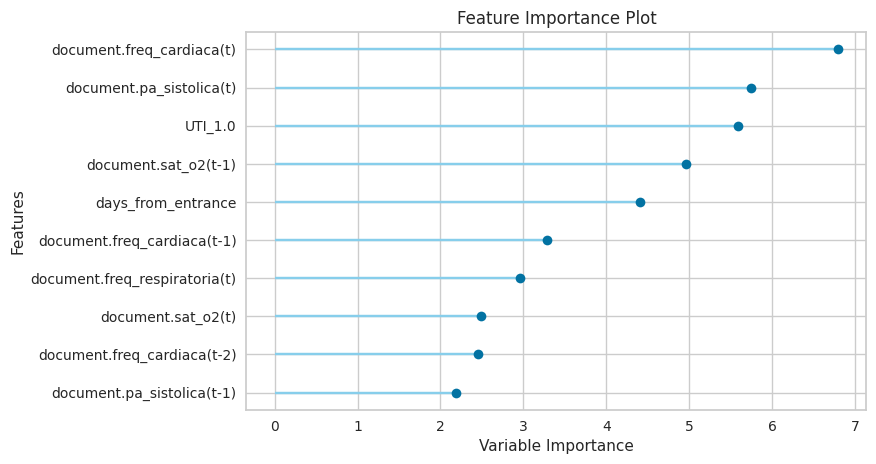

In [9]:
plot_model(best, plot='feature')